In [23]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline
from IPython.display import Javascript

# paper

In [24]:
def cal_H(theta2):

    c2 = np.cos(theta2)
    
    H = np.array([[1/3*m1*l1*l1+m2*l1*l1+1/3*m2*l2*l2+m2*l1*l2*c2, 1/3*m2*l2*l2+0.5*m2*l1*l2*c2],
                 [1/3*m2*l2*l2+1/2*m2*l1*l2*c2, 1/3*m2*l2*l2]])
    
    return H

In [25]:
def cal_C(q1_dot, q2_dot, theta2):

    c2 = np.cos(theta2)
    s2 = np.sin(theta2)
    
    h = -0.5*m2*l1*l2*s2
    C = np.array([[h*q2_dot, h*(q1_dot+q2_dot)],
                 [-h*q1_dot, 0]])
    
    return C

In [26]:
def cal_G(theta1, theta2):

    c1 = np.cos(theta1)
    c2 = np.cos(theta2)
    c12 = np.cos(theta1+theta2)
    g = 9.8
    
    G = np.array([[0.5*m1*g*l1*c1+m2*g*l1*c1+0.5*m2*g*l2*c12],
                 [0.5*m2*g*l2*c12]])
    
    return G

# SMC

In [27]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []

m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8
    
q = np.array([[0.2], [0.1]], dtype=np.float32)

q_dot = np.array([[0], [0]], dtype=np.float32)

q_dot_dot = np.array([[0], [0]], dtype=np.float32)

up = 2 * np.eye(2)

q_d = np.array([[0.5], [0.3]], dtype=np.float32)

q_d_d = np.array([[0], [0]], dtype=np.float32)

q_d_dd= np.array([[0], [0]], dtype=np.float32)

k = np.array([[9], [3]])
del_t = 0.001
        

for i in range(40000):       
    time_list.append(i)
    
    # 正弦目标
    q_d = 2 * np.ones((2,1)) * np.sin(5*i*del_t)
    q_d_d = 2 * np.ones((2,1)) * 5 * np.cos(5*i*del_t)
    q_d_dd = - 2 * np.ones((2,1)) * 25 * np.sin(5*i*del_t)
    
    for j in range(1):
        q_r_dd = q_d_dd - up.dot(q_dot-q_d_d)
        q_r_d = q_d_d - up.dot(q-q_d)

        # torque = cal_H(q_d[1][0]).dot(q_r_dd) + cal_C(q_d_d[0][0], q_d_d[1][0], q[1][0]).dot(q_r_d) + cal_G(q_d[0][0], q_d[1][0])
        torque = cal_H(q[1][0]).dot(q_r_dd) + cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_r_d) + cal_G(q[0][0], q[1][0])
        
        s = (q_dot - q_r_d)
        
        # s = s / (abs(s)) * np.clip(abs(s) * 100, 0, 1)
        s = s / (abs(s))
        #s = (q_dot - q_r_d) > 0
        

        torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) - np.multiply(k, s)
        #torque2_list.append(torque_a[1][0])
        

        q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a)

        q_dot = q_dot + q_dot_dot * del_t

        q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2

        
    s = (q_dot - q_r_d)
    s1.append(s[0][0])
    s2.append(s[1][0])
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])

# back-stepping & SMC

In [28]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []
error_list = []

# param
m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8

c1 = 2
c2 = 2
up = 1 * np.eye(2)

# state
q = np.array([[0.2], [0.1]], dtype=np.float32)
q_dot = np.array([[0], [0]], dtype=np.float32)
q_dot_dot = np.array([[0], [0]], dtype=np.float32)

# target
'''
q_d = np.array([[0.5], [0.3]], dtype=np.float32)
q_d_d = np.array([[0], [0]], dtype=np.float32)
q_d_dd= np.array([[0], [0]], dtype=np.float32)
'''
k = np.array([[1], [1]])
eita = 1
# time interval
del_t = 0.001

for i in range(8000):
    time_list.append(i * del_t)
    
    # 正弦目标
    q_d = 2 * np.ones((2,1)) * np.sin(5*i*del_t)
    q_d_d = 2 * np.ones((2,1)) * 5 * np.cos(5*i*del_t)
    q_d_dd = - 2 * np.ones((2,1)) * 25 * np.sin(5*i*del_t)
    
    z1_dot = q_dot - q_d_d
    z1 = q - q_d
    z2 = q_dot + c1 * z1 - q_d_d
    
    s = z2
    # s = s / (abs(s)) * np.clip(abs(s) * 200, 0, 1)
    s = s / (abs(s) + 0.00)
    
    torque = cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) + cal_G(q[0][0], q[1][0]) - cal_H(q[1][0]).dot(c1 * z1_dot - q_d_dd + z1 + c2 * z2 + eita * s)
        
    torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot)
    
    # 随机扰动
    error = random.random() * eita - eita / 2
    # 正弦扰动
    # error = eita * np.sin(10 *i*del_t)
    
    q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a) + error
    q_dot = q_dot + q_dot_dot * del_t
    q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2
    
    s = z2
    s1.append(s[0][0])
    s2.append(s[1][0])
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])
    error_list.append(error)

# back-stepping & robust

In [29]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []
error_list = []

# param
m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8


# state
q = np.array([[0.2], [0.1]], dtype=np.float32)
q_dot = np.array([[0], [0]], dtype=np.float32)
q_dot_dot = np.array([[0], [0]], dtype=np.float32)

# target
q_d = np.array([[5], [3]], dtype=np.float32)
q_d_d = np.array([[0], [0]], dtype=np.float32)
q_d_dd= np.array([[0], [0]], dtype=np.float32)

beta = np.array([[20], [10]])
h = 2
c1 = 2
k1 = 2
F_ = 10

# time interval
del_t = 0.001

for i in range(4000):
    time_list.append(i * del_t)
    
    # 正弦目标
    q_d = np.ones((2,1)) * np.sin(5*i*del_t)
    q_d_d = np.ones((2,1)) * 5 * np.cos(5*i*del_t)
    q_d_dd = - np.ones((2,1)) * 25 * np.sin(5*i*del_t)
    
    '''
    # target state 
    t = i / 1000
    a = 6/5
    if( i <= 1000):
        q_d_dd = np.array([[0], [a]], dtype=np.float32)
        q_d_d = np.array([[0], [a*t]], dtype=np.float32)
        q_d = np.array([[0.3], [t**2/2*a]], dtype=np.float32)
    elif( i > 3000):
        q_d_dd = np.array([[0], [-a]], dtype=np.float32)
        q_d_d = np.array([[0], [4*a-a*t]], dtype=np.float32)
        q_d = np.array([[0.3], [18/5-a/2*(4-t)**2]], dtype=np.float32)
    elif( i > 4000):
        q_d_dd = np.array([[0], [0]], dtype=np.float32)
        q_d_d = np.array([[0], [0]], dtype=np.float32)
        q_d = np.array([[0.3], [18/5]], dtype=np.float32)
    else:
        q_d_dd = np.array([[0], [0]], dtype=np.float32)
        q_d_d = np.array([[0], [a]], dtype=np.float32)
        q_d = np.array([[0.3], [a/2 + (t-1)*a]], dtype=np.float32)
    '''
        
    z1_dot = q_dot - q_d_d
    z1 = q - q_d
    z2 = q_dot + c1 * z1 - q_d_d
    
    s = k1 * z1 + z2
    s = s / (abs(s) + 0.001)
    
    torque = cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) + cal_G(q[0][0], q[1][0]) + cal_H(q[1][0]).dot(-k1*q_dot + k1*q_d_d - F_*s - c1*q_dot + c1*q_d_d + q_d_dd - h*s - h*beta*s)
  
    
    torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot)
    
    # 随机扰动
    # error = random.random() * F_
    # 正弦扰动
    error = F_ * np.sin(10 *i*del_t)
    
    
    q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a) + error
    q_dot = q_dot + q_dot_dot * del_t
    q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2
    
    s = k1 * z1 + z2
    s1.append(s[0][0])
    s2.append(s[1][0])
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    #q1_dot_list.append(q_dot[0][0])
    #q2_dot_list.append(q_dot[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])
    error_list.append(error)

# back-stepping & adaptive

In [30]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []
error_list = []

# param
m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8


# state
q = np.array([[0.2], [0.1]], dtype=np.float32)
q_dot = np.array([[0], [0]], dtype=np.float32)
q_dot_dot = np.array([[0], [0]], dtype=np.float32)

# target
q_d = np.array([[5], [3]], dtype=np.float32)
q_d_d = np.array([[0], [0]], dtype=np.float32)
q_d_dd= np.array([[0], [0]], dtype=np.float32)

beta = np.array([[20], [10]])
h = 2
c1 = 2
k1 = 2
# perturbance estimation
F_est = 0
F_est_dot = 0
gama = 10
F_ = 10

# time interval
del_t = 0.001

for i in range(4000):
    
    time_list.append(i * del_t)
    
    # 正弦目标
    q_d = np.ones((2,1)) * np.sin(5*i*del_t)
    q_d_d = np.ones((2,1)) * 5 * np.cos(5*i*del_t)
    q_d_dd = - np.ones((2,1)) * 25 * np.sin(5*i*del_t)
    
    '''
    # target state 
    t = i / 1000
    a = 6/5
    if( i <= 1000):
        q_d_dd = np.array([[0], [a]], dtype=np.float32)
        q_d_d = np.array([[0], [a*t]], dtype=np.float32)
        q_d = np.array([[0.3], [t**2/2*a]], dtype=np.float32)
    elif( i > 3000):
        q_d_dd = np.array([[0], [-a]], dtype=np.float32)
        q_d_d = np.array([[0], [4*a-a*t]], dtype=np.float32)
        q_d = np.array([[0.3], [18/5-a/2*(4-t)**2]], dtype=np.float32)
    elif( i > 4000):
        q_d_dd = np.array([[0], [0]], dtype=np.float32)
        q_d_d = np.array([[0], [0]], dtype=np.float32)
        q_d = np.array([[0.3], [18/5]], dtype=np.float32)
    else:
        q_d_dd = np.array([[0], [0]], dtype=np.float32)
        q_d_d = np.array([[0], [a]], dtype=np.float32)
        q_d = np.array([[0.3], [a/2 + (t-1)*a]], dtype=np.float32)
    '''
    
    z1_dot = q_dot - q_d_d
    z1 = q - q_d
    z2 = q_dot + c1 * z1 - q_d_d
    
    s = k1 * z1 + z2
    s = s / (abs(s) + 0.01)
    
    # estimated perturbance
    F_est_dot = - gama * s
    F_est += F_est_dot * del_t
    
    torque = cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) + cal_G(q[0][0], q[1][0]) + cal_H(q[1][0]).dot(-k1*q_dot + k1*q_d_d - F_est*s - c1*q_dot + c1*q_d_d + q_d_dd - h*s - h*beta*s)
    
    torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot)

    # 随机扰动
    # error = random.random() * F_
    # 正弦扰动
    error = F_ * np.sin(10 *i*del_t)
    
    q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a) + error
    q_dot = q_dot + q_dot_dot * del_t
    q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2
    
    s = k1 * z1 + z2
    s1.append(s[0][0])
    s2.append(s[1][0])
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    #q1_dot_list.append(q_dot[0][0])
    #q2_dot_list.append(q_dot[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])
    error_list.append(error)

# finite time terminal sliding mode (singular)

In [65]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []
error_list = []

# param
m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8


# state
q = np.array([[0.01], [0.01]], dtype=np.float32)
q_dot = np.array([[0], [0]], dtype=np.float32)
q_dot_dot = np.array([[0], [0]], dtype=np.float32)

# target
q_d = np.array([[5], [3]], dtype=np.float32)
q_d_d = np.array([[0], [0]], dtype=np.float32)
q_d_dd= np.array([[0], [0]], dtype=np.float32)



# perturbance estimation
F_est = 0
F_est_dot = 0
gama = 10
F_ = 10

c1 = 1
p = 0.5

# time interval
del_t = 0.004

for i in range(4000):
    
    time_list.append(i * del_t)
    
    # 正弦目标
    q_d = np.ones((2,1)) * np.sin(5*i*del_t)
    q_d_d = np.ones((2,1)) * 5 * np.cos(5*i*del_t)
    q_d_dd = - np.ones((2,1)) * 25 * np.sin(5*i*del_t)
    
    # 
    q_d = np.ones((2,1)) * 1
    q_d_d = np.ones((2,1)) * 0
    q_d_dd = - np.ones((2,1)) * 0
    
    '''
    # target state 
    t = i / 1000
    a = 6/5
    if( i <= 1000):
        q_d_dd = np.array([[0], [a]], dtype=np.float32)
        q_d_d = np.array([[0], [a*t]], dtype=np.float32)
        q_d = np.array([[0.3], [t**2/2*a]], dtype=np.float32)
    elif( i > 3000):
        q_d_dd = np.array([[0], [-a]], dtype=np.float32)
        q_d_d = np.array([[0], [4*a-a*t]], dtype=np.float32)
        q_d = np.array([[0.3], [18/5-a/2*(4-t)**2]], dtype=np.float32)
    elif( i > 4000):
        q_d_dd = np.array([[0], [0]], dtype=np.float32)
        q_d_d = np.array([[0], [0]], dtype=np.float32)
        q_d = np.array([[0.3], [18/5]], dtype=np.float32)
    else:
        q_d_dd = np.array([[0], [0]], dtype=np.float32)
        q_d_d = np.array([[0], [a]], dtype=np.float32)
        q_d = np.array([[0.3], [a/2 + (t-1)*a]], dtype=np.float32)
    '''
    
    z1_dot = q_dot - q_d_d
    z1 = q - q_d
    z2 = q_dot + c1 * z1 - q_d_d
    
    s = z2 + np.sign(z1) * abs(z1) ** p
    
    # control law
    torque = cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) + cal_G(q[0][0], q[1][0]) + cal_H(q[1][0]).dot(- c1*q_dot + c1*q_d_d + q_d_dd - z1_dot * abs(z1)**(p-1) * p - 0.5 * np.sign(s) * abs(s)**p)
    
    torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot)

    # 随机扰动
    # error = random.random() * F_
    # 正弦扰动
    # error = F_ * np.sin(10 *i*del_t)
    
    q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a)
    q_dot = q_dot + q_dot_dot * del_t
    q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2
    
    s = z2 + np.sign(z1) * abs(z1) ** p
    s1.append(s[0][0])
    s2.append(s[1][0])
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    #q1_dot_list.append(q_dot[0][0])
    #q2_dot_list.append(q_dot[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])
    # error_list.append(error)

# finite time terminal sliding mode (not singular)

In [58]:
q1_dot_list = []
q2_dot_list = []
q1_list = []
q2_list = []
torque1_list = []
torque2_list = []
s1 = []
s2 = []
time_list = []
error_list = []
s1_rl_list = []
s2_rl_list = []

# param
m1 = 1
m2 = 2
l1 = 2
l2 = 2
g = 9.8


# state
q = np.array([[0.01], [0.01]], dtype=np.float32)
q_dot = np.array([[0], [0]], dtype=np.float32)
q_dot_dot = np.array([[0], [0]], dtype=np.float32)

# target
q_d = np.array([[5], [3]], dtype=np.float32)
q_d_d = np.array([[0], [0]], dtype=np.float32)
q_d_dd= np.array([[0], [0]], dtype=np.float32)



# perturbance estimation
F_est = 0
F_est_dot = 0
gama = 10
F_ = 1 

c1 = 2
g = 1.8
p = 0.8

# time interval
del_t = 0.002


for i in range(8000):
    
    time_list.append(i * del_t)
    
    # 正弦目标
    q_d = np.ones((2,1)) * np.sin(5*i*del_t)
    q_d_d = np.ones((2,1)) * 5 * np.cos(5*i*del_t)
    q_d_dd = - np.ones((2,1)) * 25 * np.sin(5*i*del_t)
    
    # 
    q_d = np.ones((2,1)) * 1
    q_d_d = np.ones((2,1)) * 0
    q_d_dd = - np.ones((2,1)) * 0
    
    z1_dot = q_dot - q_d_d
    z1 = q - q_d
    z2 = q_dot + c1 * z1 - q_d_d
    
    s = z2 + np.sign(z1) * abs(z1) ** g
    
    # control law
    torque = cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot) + cal_G(q[0][0], q[1][0]) + cal_H(q[1][0]).dot(- c1*z1_dot + q_d_dd - g*abs(z1)**(g-1)*(z2-c1*z1) -0.5*np.sign(s)*abs(s)**p)
    
    torque_a = torque - cal_G(q[0][0], q[1][0]) - cal_C(q_dot[0][0], q_dot[1][0], q[1][0]).dot(q_dot)
    
    # 随机扰动
    # error = random.random() * F_
    # 正弦扰动
    # error = F_ * np.sin(10 *i*del_t)
    
    q_dot_dot = np.linalg.inv(cal_H(q[1][0])).dot(torque_a)
    q_dot = q_dot + q_dot_dot * del_t
    q = q + q_dot * del_t + 0.5 * q_dot_dot * del_t**2

    
    s = z1 + np.sign(z2) * abs(z2) ** g
    s1.append(s[0][0])
    s2.append(s[1][0])
    q1_dot_list.append(q_dot[0][0] - q_d_d[0][0])
    q2_dot_list.append(q_dot[1][0] - q_d_d[1][0])
    #q1_dot_list.append(q_dot[0][0])
    #q2_dot_list.append(q_dot[1][0])
    q1_list.append(q[0][0] - q_d[0][0])
    q2_list.append(q[1][0] - q_d[1][0])
    torque1_list.append(torque[0][0])
    torque2_list.append(torque[1][0])
    # error_list.append(error)

In [59]:
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False

In [66]:
print( sum(abs(np.array(s1))), sum(abs(np.array(s2))) )

934.7888842449512 934.7888845388904


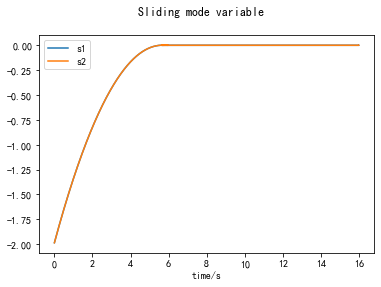

In [67]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list, s1, label="s1")
plt.plot(time_list, s2, label="s2")
plt.xlabel('time/s')
plt.legend()

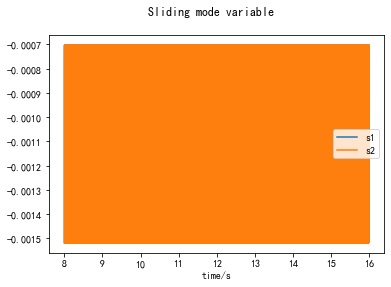

In [71]:
plt.suptitle('Sliding mode variable')
plt.plot(time_list[2000:], s1[2000:], label="s1")
plt.plot(time_list[2000:], s2[2000:], label="s2")
plt.xlabel('time/s')
plt.legend()

In [37]:
print( sum(abs(np.array(torque1_list))), sum(abs(np.array(torque2_list))) )

144335.09026517585 57597.37948760307


In [38]:
print( sum(abs(np.array(torque1_list[1:]) - np.array(torque1_list[:-1]))), \
      sum(abs(np.array(torque2_list[1:]) - np.array(torque2_list[:-1]))) )

556.7176515643847 180.65438884620852


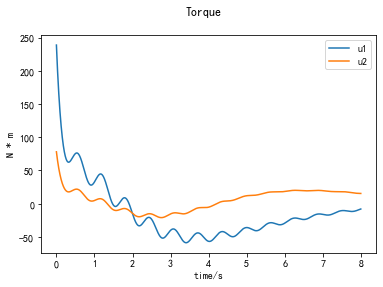

In [39]:
plt.suptitle('Torque')
plt.plot(time_list, torque1_list, label="u1")
plt.plot(time_list, torque2_list, label="u2")
plt.xlabel('time/s')
plt.ylabel('N * m')
plt.legend()

In [40]:
print( sum(abs(np.array(q1_list))), sum(abs(np.array(q2_list))) )

10175.418708092635 5338.893714209801


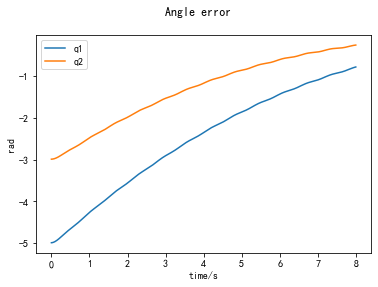

In [41]:
plt.suptitle('Angle error')
plt.plot(time_list, q1_list, label="q1")
plt.plot(time_list, q2_list, label="q2")
plt.xlabel('time/s')
plt.ylabel('rad')
plt.legend()

In [42]:
print( sum(abs(np.array(q1_dot_list)**2)) **0.5, sum(abs(np.array(q2_dot_list)**2)) **0.5 )

34.972541643961165 23.55029492217458


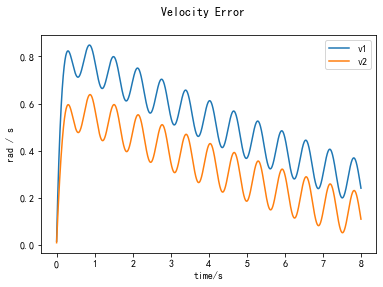

In [43]:
plt.suptitle('Velocity Error')
plt.plot(time_list, q1_dot_list, label="v1")
plt.plot(time_list, q2_dot_list, label="v2")
plt.xlabel('time/s')
plt.ylabel('rad / s')
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (4000,) and (0,)

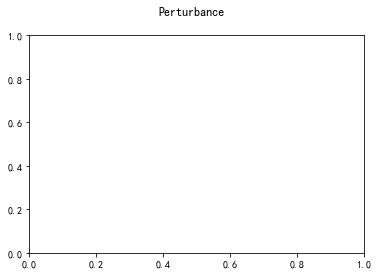

In [44]:
plt.suptitle('Perturbance')
plt.plot(time_list, error_list, label="perturbance")
plt.xlabel('time/s')
plt.ylabel('rad/s^2')
plt.legend()

In [ ]:
np.arctan(5) * 180 / np.pi

In [ ]:
float(np.infty)